In [ ]:
# dataset split

import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
source_dir = '/gpfs/scratch/dl3607/dl/multiclassification/data/all_image'
dest_dir = '/gpfs/scratch/dl3607/dl/multiclassification/data'

# Create split directories
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(dest_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    
    # Create class subdirectories
    for cls in ['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

# Split ratios
test_size = 0.2  # 20% for test
val_size = 0.125  # 10% of the remaining 80% = 12.5% of total

# Process each class
for cls in ['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']:
    cls_path = os.path.join(source_dir, cls)
    images = [f for f in os.listdir(cls_path) if f.endswith('.png')]
    
    # First split: separate test set
    train_val_files, test_files = train_test_split(
        images, test_size=test_size, random_state=42
    )
    
    # Second split: separate validation from training
    train_files, val_files = train_test_split(
        train_val_files, test_size=val_size, random_state=42
    )
    
    # Copy files to their destinations
    for img, dest_split in [
        (train_files, 'train'), 
        (val_files, 'val'), 
        (test_files, 'test')
    ]:
        for filename in img:
            src = os.path.join(cls_path, filename)
            dst = os.path.join(dest_dir, dest_split, cls, filename)
            shutil.copy2(src, dst)
    
    print(f"{cls}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

print("Dataset splitting complete!")

In [45]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

def load_data_paths(base_path, split="train"):
    """
    Load image paths and labels from the dataset directory.
    
    Args:
        base_path: Base path to the dataset directory
        split: Data split to use ('train', 'val', or 'test')
        
    Returns:
        image_paths: List of image paths
        labels: List of corresponding labels
        class_names: List of class names
    """
    # Path to the split directory
    split_path = os.path.join(base_path, split)
    
    # Get all class directories
    class_names = sorted([d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))])
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    image_paths = []
    labels = []
    
    # Traverse through each class directory
    for class_name in class_names:
        class_dir = os.path.join(split_path, class_name)
        
        # Get all image paths in the directory
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, img_name)
                image_paths.append(img_path)
                labels.append(class_to_idx[class_name])
    
    return image_paths, labels, class_names

base_path = "/gpfs/scratch/dl3607/dl/multiclassification/data"
train_paths, train_labels, class_names = load_data_paths(base_path, "train")
val_paths, val_labels, _ = load_data_paths(base_path, "val")
test_paths, test_labels, _ = load_data_paths(base_path, "test")

print(f"Classes: {class_names}")
print(f"Training images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")
print(f"Test images: {len(test_paths)}")

Classes: ['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']
Training images: 21760
Validation images: 3112
Test images: 6224


In [46]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

# Custom dataset class
class GastricCancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define transforms for training and validation/testing
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = GastricCancerDataset(train_paths, train_labels, transform=train_transform)
val_dataset = GastricCancerDataset(val_paths, val_labels, transform=val_transform)
test_dataset = GastricCancerDataset(test_paths, test_labels, transform=val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Check data dimensions
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break

/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])


In [26]:
# EfficientNetV2 with attention
import timm
import torch.nn as nn

class AttentionEfficientNetV2(nn.Module):
    def __init__(self, num_classes=8, pretrained=True, dropout_rate=0.3):
        super(AttentionEfficientNetV2, self).__init__()
        # Load pretrained EfficientNetV2
        self.backbone = timm.create_model('tf_efficientnetv2_s', pretrained=pretrained)
        self.num_features = self.backbone.classifier.in_features
        
        # Remove the original classifier
        self.backbone.classifier = nn.Identity()
        
        # Add attention mechanism with batch normalization
        self.attention = nn.Sequential(
            nn.Linear(self.num_features, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )
        
        # Additional layers with batch normalization
        self.bn = nn.BatchNorm1d(self.num_features)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Final classifier
        self.classifier = nn.Linear(self.num_features, num_classes)
        
    def forward(self, x):
        # Extract features
        features = self.backbone(x)
        
        # Apply batch normalization
        normalized_features = self.bn(features)
        
        # Apply attention
        attention_weights = self.attention(normalized_features).softmax(dim=1)
        weighted_features = normalized_features * attention_weights
        
        # Apply dropout for regularization
        weighted_features = self.dropout(weighted_features)
        
        # Classify
        output = self.classifier(weighted_features)
        return output, attention_weights

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

def train_model(model, train_loader, val_loader, num_classes, num_epochs=20, learning_rate=1e-4, save_path='model_checkpoint'):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    
    # Training loop
    best_val_auc = 0.0
    best_model_path = f'{save_path}_best.pth'
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            labels = labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / total
        train_acc = correct / total
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        # For metrics calculation
        all_labels = []
        all_predictions = []
        all_probs = []
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs, _ = model(images)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # Store for metrics calculation
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
        
        # Convert to numpy arrays
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        all_probs = np.array(all_probs)
        
        # Calculate metrics
        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        
        # Calculate AUC
        try:
            val_auc = roc_auc_score(
                np.eye(num_classes)[all_labels], 
                all_probs, 
                multi_class='ovr', 
                average='macro'
            )
            
            # Calculate per-class AUC
            class_aucs = []
            for i in range(num_classes):
                if i in all_labels:
                    class_auc = roc_auc_score((all_labels == i).astype(int), all_probs[:, i])
                    class_aucs.append((i, class_auc))
                    
            # Print per-class AUCs
            print("Per-class AUCs:")
            for class_idx, auc in class_aucs:
                print(f"Class {class_idx}: AUC = {auc:.4f}")
                
        except ValueError:
            val_auc = 0.0
        
        # Other metrics
        precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Calculate time elapsed
        epoch_time = time.time() - epoch_start
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {epoch_time:.1f}s")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        
        # Compute confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        print("Confusion Matrix:")
        print(conf_matrix)






In [32]:
# Initialize your model
model = AttentionEfficientNetV2(num_classes=8)

# Train model
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_classes=8,
    num_epochs=20,
)

Using device: cuda


Epoch 1/20 - Validation: 100%|██████████| 98/98 [00:18<00:00,  5.35it/s]


Per-class AUCs:
Class 0: AUC = 0.9804
Class 1: AUC = 0.9479
Class 2: AUC = 0.9822
Class 3: AUC = 0.9497
Class 4: AUC = 0.9615
Class 5: AUC = 0.9171
Class 6: AUC = 0.9377
Class 7: AUC = 0.9474
Epoch 1/20 - Time: 141.6s
Train Loss: 1.0452, Train Acc: 0.6081
Val Loss: 0.7987, Val Acc: 0.6886, Val AUC: 0.9530
Precision: 0.6995, Recall: 0.6886, F1: 0.6906
Confusion Matrix:
[[279   7   0  74   6  21   1   1]
 [  2 265  17  25  16  13  21  30]
 [  3  21 301   2   3  28  11  20]
 [ 22  22   0 295   7  27   6  10]
 [ 14  20   3  18 278  11  40   5]
 [ 10  17  16  47   5 217  11  66]
 [  2  29   7  13  34  22 226  56]
 [  3  19   6  20   2  41  16 282]]


Epoch 2/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/20 - Validation: 100%|██████████| 98/98 [00:12<00:00,  7.99it/s]


Per-class AUCs:
Class 0: AUC = 0.9830
Class 1: AUC = 0.9530
Class 2: AUC = 0.9861
Class 3: AUC = 0.9553
Class 4: AUC = 0.9648
Class 5: AUC = 0.9328
Class 6: AUC = 0.9394
Class 7: AUC = 0.9529
Epoch 2/20 - Time: 136.6s
Train Loss: 0.7760, Train Acc: 0.7065
Val Loss: 0.7515, Val Acc: 0.7021, Val AUC: 0.9584
Precision: 0.7107, Recall: 0.7021, F1: 0.7038
Confusion Matrix:
[[302  10   0  44  11  21   1   0]
 [  2 287  14  11  12  11  17  35]
 [  1  25 303   1   5  27  10  17]
 [ 33  46   0 244   9  34  11  12]
 [ 19  28   4   8 285   7  29   9]
 [  7  24  11  20   5 244  18  60]
 [  1  20   6   6  56  21 233  46]
 [  2  18   1   9   3  49  20 287]]


Epoch 3/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/20 - Validation: 100%|██████████| 98/98 [00:12<00:00,  7.94it/s]


Per-class AUCs:
Class 0: AUC = 0.9860
Class 1: AUC = 0.9582
Class 2: AUC = 0.9871
Class 3: AUC = 0.9636
Class 4: AUC = 0.9689
Class 5: AUC = 0.9378
Class 6: AUC = 0.9509
Class 7: AUC = 0.9554
Epoch 3/20 - Time: 133.5s
Train Loss: 0.6679, Train Acc: 0.7454
Val Loss: 0.7037, Val Acc: 0.7233, Val AUC: 0.9635
Precision: 0.7296, Recall: 0.7233, F1: 0.7235
Confusion Matrix:
[[281   7   0  67   8  24   1   1]
 [  2 270  32  23  12  16  16  18]
 [  0  14 344   2   1  19   6   3]
 [ 13  13   2 306   7  29   7  12]
 [ 13  19   3  12 297   8  35   2]
 [  3   7  24  25   4 263  25  38]
 [  2  22  14  15  39  21 254  22]
 [  2  24  17  14   3  56  37 236]]


Epoch 4/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/20 - Validation: 100%|██████████| 98/98 [00:14<00:00,  6.96it/s]


Per-class AUCs:
Class 0: AUC = 0.9854
Class 1: AUC = 0.9551
Class 2: AUC = 0.9877
Class 3: AUC = 0.9666
Class 4: AUC = 0.9683
Class 5: AUC = 0.9394
Class 6: AUC = 0.9538
Class 7: AUC = 0.9595
Epoch 4/20 - Time: 133.6s
Train Loss: 0.5897, Train Acc: 0.7777
Val Loss: 0.6994, Val Acc: 0.7330, Val AUC: 0.9645
Precision: 0.7362, Recall: 0.7330, F1: 0.7320
Confusion Matrix:
[[288   6   3  51  12  26   0   3]
 [  2 269  35  17  18  18  12  18]
 [  0  11 354   0   1   9   2  12]
 [ 19  14   1 307  11  18   8  11]
 [ 16  12   9   9 306   7  27   3]
 [  2  11  28  34   4 256  22  32]
 [  1  23  21  17  37  15 242  33]
 [  0  26   9  16   4  57  18 259]]


Epoch 5/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/20 - Validation: 100%|██████████| 98/98 [00:15<00:00,  6.27it/s]


Per-class AUCs:
Class 0: AUC = 0.9834
Class 1: AUC = 0.9569
Class 2: AUC = 0.9886
Class 3: AUC = 0.9603
Class 4: AUC = 0.9720
Class 5: AUC = 0.9350
Class 6: AUC = 0.9516
Class 7: AUC = 0.9532
Epoch 5/20 - Time: 140.1s
Train Loss: 0.5071, Train Acc: 0.8104
Val Loss: 0.7275, Val Acc: 0.7304, Val AUC: 0.9626
Precision: 0.7325, Recall: 0.7304, F1: 0.7306
Confusion Matrix:
[[309   7   1  26  14  27   2   3]
 [  3 286  20  20  17  13  15  15]
 [  0  20 343   1   4  10   6   5]
 [ 41  22   0 283   3  29   4   7]
 [ 10  16   3   9 285   8  52   6]
 [  4  16  25  32   4 249  19  40]
 [  1  22  14  17  18  16 270  31]
 [  2  27  10  19   3  59  21 248]]


Epoch 6/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/20 - Validation: 100%|██████████| 98/98 [00:12<00:00,  7.98it/s]


Per-class AUCs:
Class 0: AUC = 0.9844
Class 1: AUC = 0.9560
Class 2: AUC = 0.9855
Class 3: AUC = 0.9628
Class 4: AUC = 0.9735
Class 5: AUC = 0.9310
Class 6: AUC = 0.9489
Class 7: AUC = 0.9490
Epoch 6/20 - Time: 134.9s
Train Loss: 0.4274, Train Acc: 0.8415
Val Loss: 0.7928, Val Acc: 0.7237, Val AUC: 0.9614
Precision: 0.7292, Recall: 0.7237, F1: 0.7220
Confusion Matrix:
[[273  10   3  65  19  15   0   4]
 [  3 279  23  22  12  11  13  26]
 [  0  18 351   0   2  11   3   4]
 [  9  15   0 312  10  22   6  15]
 [  4  22   5   8 315   6  25   4]
 [  6  13  46  25   8 235  10  46]
 [  0  19  29  13  44  21 232  31]
 [  2  22  19  14   2  45  30 255]]


Epoch 7/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/20 - Validation: 100%|██████████| 98/98 [00:12<00:00,  7.95it/s]


Per-class AUCs:
Class 0: AUC = 0.9856
Class 1: AUC = 0.9573
Class 2: AUC = 0.9860
Class 3: AUC = 0.9605
Class 4: AUC = 0.9713
Class 5: AUC = 0.9367
Class 6: AUC = 0.9460
Class 7: AUC = 0.9540
Epoch 7/20 - Time: 134.7s
Train Loss: 0.3498, Train Acc: 0.8702
Val Loss: 0.7822, Val Acc: 0.7343, Val AUC: 0.9622
Precision: 0.7338, Recall: 0.7343, F1: 0.7326
Confusion Matrix:
[[333   7   0  20  18   6   0   5]
 [  4 300  16  11  16  11  15  16]
 [  1  24 332   0   3   9  11   9]
 [ 40  33   1 269   9  17   8  12]
 [ 10  17   3   6 302   6  42   3]
 [ 13  14  27  30  11 221  31  42]
 [  1  22  17  10  26  11 274  28]
 [  5  26  11  14   1  42  36 254]]


Epoch 8/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/20 - Validation: 100%|██████████| 98/98 [00:12<00:00,  7.98it/s]


Per-class AUCs:
Class 0: AUC = 0.9827
Class 1: AUC = 0.9462
Class 2: AUC = 0.9866
Class 3: AUC = 0.9610
Class 4: AUC = 0.9703
Class 5: AUC = 0.9370
Class 6: AUC = 0.9407
Class 7: AUC = 0.9506
Epoch 8/20 - Time: 137.0s
Train Loss: 0.3032, Train Acc: 0.8895
Val Loss: 0.8764, Val Acc: 0.7275, Val AUC: 0.9594
Precision: 0.7329, Recall: 0.7275, F1: 0.7279
Confusion Matrix:
[[277   4   2  58  24  18   3   3]
 [  5 274  19  25  12  14  13  27]
 [  1  24 327   1   2   9   8  17]
 [ 18  20   0 312   7  17   7   8]
 [  5  22   2   8 305   5  36   6]
 [  1  10  30  34   8 251  18  37]
 [  0  24  10  14  36  16 248  41]
 [  2  25   8  13   3  45  23 270]]


Epoch 9/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/20 - Validation: 100%|██████████| 98/98 [00:15<00:00,  6.31it/s]


Per-class AUCs:
Class 0: AUC = 0.9867
Class 1: AUC = 0.9547
Class 2: AUC = 0.9872
Class 3: AUC = 0.9634
Class 4: AUC = 0.9740
Class 5: AUC = 0.9417
Class 6: AUC = 0.9485
Class 7: AUC = 0.9563
Epoch 9/20 - Time: 138.3s
Train Loss: 0.1888, Train Acc: 0.9358
Val Loss: 0.8075, Val Acc: 0.7410, Val AUC: 0.9641
Precision: 0.7392, Recall: 0.7410, F1: 0.7392
Confusion Matrix:
[[327   2   3  25  17  13   0   2]
 [  6 271  24  24  14  10  18  22]
 [  2  17 346   1   0   8   5  10]
 [ 32  24   0 291   6  19   6  11]
 [ 14  13   4   7 305   5  35   6]
 [ 10  10  36  23   8 245  18  39]
 [  2  17  20  14  39  15 251  31]
 [  4  19  12  16   4  38  26 270]]


Epoch 10/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/20 - Validation: 100%|██████████| 98/98 [00:14<00:00,  6.98it/s]


Per-class AUCs:
Class 0: AUC = 0.9869
Class 1: AUC = 0.9547
Class 2: AUC = 0.9874
Class 3: AUC = 0.9641
Class 4: AUC = 0.9748
Class 5: AUC = 0.9419
Class 6: AUC = 0.9472
Class 7: AUC = 0.9551
Epoch 10/20 - Time: 135.5s
Train Loss: 0.1532, Train Acc: 0.9489
Val Loss: 0.8237, Val Acc: 0.7365, Val AUC: 0.9640
Precision: 0.7361, Recall: 0.7365, F1: 0.7349
Confusion Matrix:
[[325   3   2  27  16  10   0   6]
 [  5 275  21  23  15   8  18  24]
 [  1  21 335   1   4   7   8  12]
 [ 27  24   0 294   9  16   6  13]
 [ 13  16   3   7 310   5  28   7]
 [  8  14  34  23  11 231  21  47]
 [  0  23  13  13  49  15 243  33]
 [  4  24   8  15   3  30  26 279]]


Epoch 11/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11/20 - Validation: 100%|██████████| 98/98 [00:12<00:00,  7.89it/s]


Per-class AUCs:
Class 0: AUC = 0.9861
Class 1: AUC = 0.9526
Class 2: AUC = 0.9873
Class 3: AUC = 0.9629
Class 4: AUC = 0.9746
Class 5: AUC = 0.9408
Class 6: AUC = 0.9482
Class 7: AUC = 0.9537
Epoch 11/20 - Time: 137.9s
Train Loss: 0.1334, Train Acc: 0.9565
Val Loss: 0.8461, Val Acc: 0.7400, Val AUC: 0.9633
Precision: 0.7393, Recall: 0.7400, F1: 0.7384
Confusion Matrix:
[[325   2   2  28  17  11   0   4]
 [  6 268  19  21  16  11  19  29]
 [  2  19 335   0   2  10   8  13]
 [ 27  21   0 295   8  18   6  14]
 [ 11  15   3   8 319   6  20   7]
 [ 10  10  31  22   9 245  20  42]
 [  2  22  12  12  48  19 234  40]
 [  5  15   9  15   4  36  23 282]]


Epoch 12/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12/20 - Validation: 100%|██████████| 98/98 [00:16<00:00,  6.11it/s]


Per-class AUCs:
Class 0: AUC = 0.9852
Class 1: AUC = 0.9542
Class 2: AUC = 0.9869
Class 3: AUC = 0.9627
Class 4: AUC = 0.9736
Class 5: AUC = 0.9418
Class 6: AUC = 0.9488
Class 7: AUC = 0.9532
Epoch 12/20 - Time: 141.5s
Train Loss: 0.1155, Train Acc: 0.9641
Val Loss: 0.8562, Val Acc: 0.7343, Val AUC: 0.9633
Precision: 0.7350, Recall: 0.7343, F1: 0.7343
Confusion Matrix:
[[317   4   2  31  17  13   0   5]
 [  5 279  18  20  14  13  19  21]
 [  2  24 317   2   3  16  12  13]
 [ 23  24   0 299   7  18   6  12]
 [ 12  19   2  10 307   6  28   5]
 [ 10  12  25  25   9 256  19  33]
 [  0  24  11  15  39  18 248  34]
 [  4  26   4  14   5  44  30 262]]


Epoch 13/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13/20 - Validation: 100%|██████████| 98/98 [00:14<00:00,  6.89it/s]


Per-class AUCs:
Class 0: AUC = 0.9858
Class 1: AUC = 0.9544
Class 2: AUC = 0.9872
Class 3: AUC = 0.9633
Class 4: AUC = 0.9746
Class 5: AUC = 0.9414
Class 6: AUC = 0.9497
Class 7: AUC = 0.9534
Epoch 13/20 - Time: 133.4s
Train Loss: 0.1094, Train Acc: 0.9662
Val Loss: 0.8492, Val Acc: 0.7375, Val AUC: 0.9637
Precision: 0.7382, Recall: 0.7375, F1: 0.7369
Confusion Matrix:
[[322   3   2  30  14  13   0   5]
 [  4 269  20  24  13  11  20  28]
 [  2  20 334   2   2  11   5  13]
 [ 23  20   0 305   4  19   6  12]
 [ 14  19   3  10 296   6  34   7]
 [  9  10  32  25   7 235  21  50]
 [  1  20  13  16  29  16 257  37]
 [  3  20  10  18   1  35  25 277]]


Epoch 14/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 14/20 - Validation: 100%|██████████| 98/98 [00:14<00:00,  6.99it/s]


Per-class AUCs:
Class 0: AUC = 0.9859
Class 1: AUC = 0.9544
Class 2: AUC = 0.9874
Class 3: AUC = 0.9633
Class 4: AUC = 0.9745
Class 5: AUC = 0.9416
Class 6: AUC = 0.9494
Class 7: AUC = 0.9537
Epoch 14/20 - Time: 136.5s
Train Loss: 0.1024, Train Acc: 0.9680
Val Loss: 0.8489, Val Acc: 0.7378, Val AUC: 0.9638
Precision: 0.7379, Recall: 0.7378, F1: 0.7369
Confusion Matrix:
[[317   3   1  32  17  15   0   4]
 [  4 272  21  25  15  12  18  22]
 [  0  20 337   1   3  13   5  10]
 [ 25  19   0 300   6  21   6  12]
 [ 12  19   4   9 309   6  23   7]
 [  9  10  31  24   7 253  17  38]
 [  1  25  12  15  43  22 239  32]
 [  4  19   7  17   4  48  21 269]]


Epoch 15/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 15/20 - Validation: 100%|██████████| 98/98 [00:15<00:00,  6.21it/s]


Per-class AUCs:
Class 0: AUC = 0.9853
Class 1: AUC = 0.9543
Class 2: AUC = 0.9872
Class 3: AUC = 0.9631
Class 4: AUC = 0.9740
Class 5: AUC = 0.9417
Class 6: AUC = 0.9488
Class 7: AUC = 0.9519
Epoch 15/20 - Time: 141.2s
Train Loss: 0.0988, Train Acc: 0.9698
Val Loss: 0.8600, Val Acc: 0.7371, Val AUC: 0.9633
Precision: 0.7381, Recall: 0.7371, F1: 0.7369
Confusion Matrix:
[[324   4   2  25  14  15   0   5]
 [  5 282  19  18  12  12  16  25]
 [  2  21 330   0   1  15   7  13]
 [ 25  26   0 292   6  20   6  14]
 [ 14  21   3   8 301   6  29   7]
 [  8   9  29  21   7 251  17  47]
 [  1  26  11  13  40  20 240  38]
 [  4  21   5  14   2  49  20 274]]


Epoch 16/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 16/20 - Validation: 100%|██████████| 98/98 [00:12<00:00,  7.98it/s]


Per-class AUCs:
Class 0: AUC = 0.9854
Class 1: AUC = 0.9545
Class 2: AUC = 0.9870
Class 3: AUC = 0.9625
Class 4: AUC = 0.9739
Class 5: AUC = 0.9413
Class 6: AUC = 0.9489
Class 7: AUC = 0.9525
Epoch 16/20 - Time: 140.6s
Train Loss: 0.1027, Train Acc: 0.9671
Val Loss: 0.8602, Val Acc: 0.7359, Val AUC: 0.9632
Precision: 0.7378, Recall: 0.7359, F1: 0.7360
Confusion Matrix:
[[308   4   1  34  18  19   0   5]
 [  4 282  20  20  11  12  16  24]
 [  0  22 333   2   1  14   7  10]
 [ 21  24   0 302   5  20   6  11]
 [ 13  22   3  11 298   7  29   6]
 [  8  10  29  24   6 258  18  36]
 [  0  26  12  16  35  19 249  32]
 [  3  29   5  17   2  50  23 260]]


Epoch 17/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 17/20 - Validation: 100%|██████████| 98/98 [00:14<00:00,  7.00it/s]


Per-class AUCs:
Class 0: AUC = 0.9857
Class 1: AUC = 0.9538
Class 2: AUC = 0.9871
Class 3: AUC = 0.9634
Class 4: AUC = 0.9734
Class 5: AUC = 0.9415
Class 6: AUC = 0.9470
Class 7: AUC = 0.9539
Epoch 17/20 - Time: 133.6s
Train Loss: 0.1015, Train Acc: 0.9673
Val Loss: 0.8652, Val Acc: 0.7394, Val AUC: 0.9632
Precision: 0.7389, Recall: 0.7394, F1: 0.7383
Confusion Matrix:
[[316   4   2  30  19  13   0   5]
 [  4 274  21  22  14  10  20  24]
 [  0  16 341   0   3  11   7  11]
 [ 21  21   0 302   8  20   6  11]
 [ 12  18   3   8 311   6  24   7]
 [  9  10  31  24   9 250  19  37]
 [  0  25  14  13  46  19 243  29]
 [  3  28   8  15   3  43  25 264]]


Epoch 18/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 18/20 - Validation: 100%|██████████| 98/98 [00:12<00:00,  7.98it/s]


Per-class AUCs:
Class 0: AUC = 0.9848
Class 1: AUC = 0.9547
Class 2: AUC = 0.9873
Class 3: AUC = 0.9633
Class 4: AUC = 0.9737
Class 5: AUC = 0.9411
Class 6: AUC = 0.9480
Class 7: AUC = 0.9516
Epoch 18/20 - Time: 139.7s
Train Loss: 0.1005, Train Acc: 0.9682
Val Loss: 0.8674, Val Acc: 0.7397, Val AUC: 0.9631
Precision: 0.7411, Recall: 0.7397, F1: 0.7393
Confusion Matrix:
[[317   3   2  35  16  12   0   4]
 [  4 263  18  26  18  14  20  26]
 [  1  19 325   2   3  16   9  14]
 [ 22  15   0 308   7  20   7  10]
 [ 12  12   3   8 317   7  24   6]
 [  9   7  24  26   9 265  16  33]
 [  0  18  11  16  47  20 244  33]
 [  3  16   5  19   4  52  27 263]]


Epoch 19/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 19/20 - Validation: 100%|██████████| 98/98 [00:15<00:00,  6.15it/s]


Per-class AUCs:
Class 0: AUC = 0.9844
Class 1: AUC = 0.9540
Class 2: AUC = 0.9870
Class 3: AUC = 0.9629
Class 4: AUC = 0.9742
Class 5: AUC = 0.9411
Class 6: AUC = 0.9490
Class 7: AUC = 0.9531
Epoch 19/20 - Time: 134.3s
Train Loss: 0.0970, Train Acc: 0.9704
Val Loss: 0.8674, Val Acc: 0.7362, Val AUC: 0.9632
Precision: 0.7368, Recall: 0.7362, F1: 0.7355
Confusion Matrix:
[[313   4   2  32  19  14   0   5]
 [  3 275  19  23  14  12  16  27]
 [  1  19 336   2   1  12   6  12]
 [ 21  20   0 305   5  20   6  12]
 [ 13  19   4   8 303   6  28   8]
 [  7  11  29  26   7 248  20  41]
 [  1  25  16  15  39  18 239  36]
 [  3  22   9  16   3  43  21 272]]


Epoch 20/20 - Training:   0%|          | 0/680 [00:00<?, ?it/s]/gpfs/scratch/dl3607/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 20/20 - Validation: 100%|██████████| 98/98 [00:14<00:00,  6.92it/s]

Per-class AUCs:
Class 0: AUC = 0.9858
Class 1: AUC = 0.9549
Class 2: AUC = 0.9871
Class 3: AUC = 0.9630
Class 4: AUC = 0.9741
Class 5: AUC = 0.9415
Class 6: AUC = 0.9483
Class 7: AUC = 0.9531
Epoch 20/20 - Time: 131.8s
Train Loss: 0.1006, Train Acc: 0.9688
Val Loss: 0.8567, Val Acc: 0.7378, Val AUC: 0.9635
Precision: 0.7387, Recall: 0.7378, F1: 0.7372
Confusion Matrix:
[[319   3   1  29  16  16   0   5]
 [  5 276  20  19  13  12  17  27]
 [  0  19 332   1   3  16   5  13]
 [ 24  26   0 292   7  21   6  13]
 [ 12  19   3   7 313   6  23   6]
 [  9   9  29  22   7 259  16  38]
 [  0  23  11  13  47  22 235  38]
 [  3  23   8  14   4  48  19 270]]


In [38]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

torch.save({
    'epoch': 19,  # zero-indexed, so epoch 20 is index 19
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # only if you plan to continue training
    'val_loss': 0.8567,
    'val_acc': 0.7378,
    'val_auc': 0.9635,
    'precision': 0.7387,
    'recall': 0.7378,
    'f1': 0.7372,
}, 'model_checkpoint_final.pth')

print("💾 Saved full final checkpoint to: model_checkpoint_final.pth")



💾 Saved full final checkpoint to: model_checkpoint_final.pth


In [39]:
torch.save(model.state_dict(), 'model_checkpoint_final_state_dict.pth')
print("✅ Saved clean model state_dict to: model_checkpoint_final_state_dict.pth")

✅ Saved clean model state_dict to: model_checkpoint_final_state_dict.pth


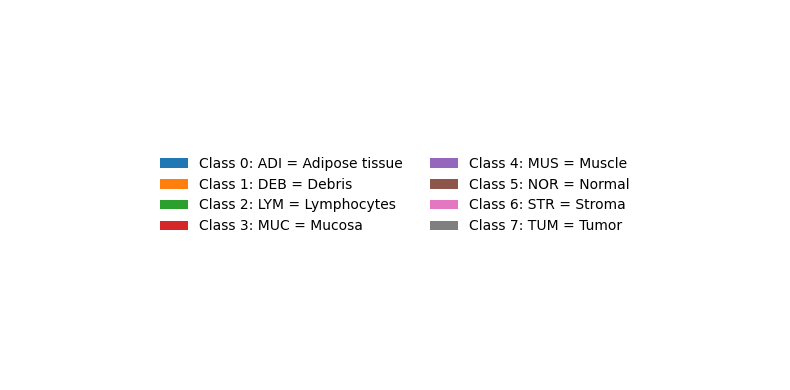

In [55]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Abbreviations, full names, and class indices
labels_info = [
    (0, 'ADI', 'Adipose tissue'),
    (1, 'DEB', 'Debris'),
    (2, 'LYM', 'Lymphocytes'),
    (3, 'MUC', 'Mucosa'),
    (4, 'MUS', 'Muscle'),
    (5, 'NOR', 'Normal'),
    (6, 'STR', 'Stroma'),
    (7, 'TUM', 'Tumor')
]

# Distinct colors for each class
colors = [
    '#1f77b4',  # ADI
    '#ff7f0e',  # DEB
    '#2ca02c',  # LYM
    '#d62728',  # MUC
    '#9467bd',  # MUS
    '#8c564b',  # NOR
    '#e377c2',  # STR
    '#7f7f7f'   # TUM
]

# Create legend handles
legend_elements = [
    Patch(facecolor=colors[i], label=f'Class {cls}: {abbr} = {full}')
    for i, (cls, abbr, full) in enumerate(labels_info)
]

# Plot legend
fig, ax = plt.subplots(figsize=(8, 4))
ax.legend(handles=legend_elements, loc='center', frameon=False, ncol=2)
ax.axis('off')
plt.tight_layout()
plt.show()


In [47]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

# Step 1: Load model architecture
model = AttentionEfficientNetV2(num_classes=8)
model.load_state_dict(torch.load('model_checkpoint_final_state_dict.pth'))
model.eval()
model = model.cuda() if torch.cuda.is_available() else model

# Step 2: Evaluate on test set
all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda() if torch.cuda.is_available() else images
        labels = labels.cpu().numpy()
        
        outputs, _ = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        
        all_labels.extend(labels)
        all_predictions.extend(preds)
        all_probs.extend(probs)

# Step 3: Metrics
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='macro')
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')

# AUC per class
try:
    auc_macro = roc_auc_score(np.eye(8)[all_labels], all_probs, multi_class='ovr', average='macro')
    print(f"Test AUC (macro): {auc_macro:.4f}")
except:
    auc_macro = None
    print("AUC could not be computed (e.g., one class missing in test set)")

conf_matrix = confusion_matrix(all_labels, all_predictions)

Test AUC (macro): 0.9661


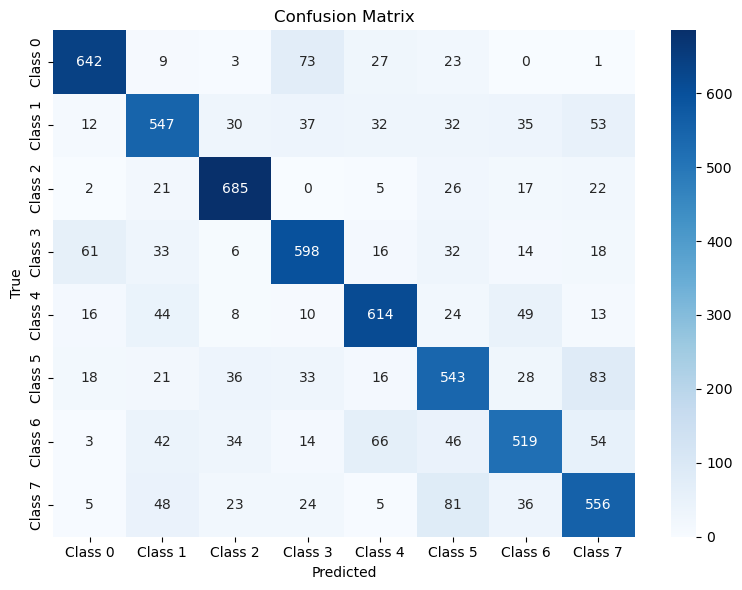

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in range(8)],
            yticklabels=[f'Class {i}' for i in range(8)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

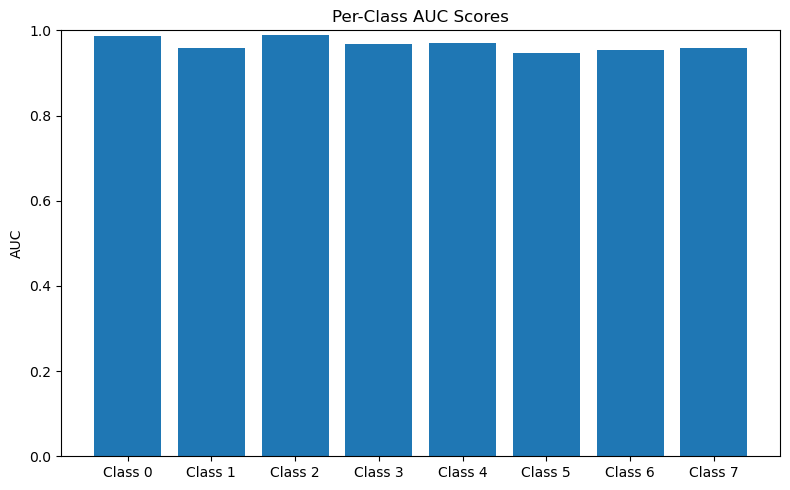

In [49]:
from sklearn.metrics import roc_auc_score

class_aucs = []
for i in range(8):
    if i in all_labels:
        auc = roc_auc_score((all_labels == i).astype(int), all_probs[:, i])
        class_aucs.append(auc)
    else:
        class_aucs.append(0.0)  # Or np.nan if you'd rather leave out

plt.figure(figsize=(8, 5))
plt.bar(range(8), class_aucs)
plt.xticks(range(8), [f'Class {i}' for i in range(8)])
plt.ylim(0.0, 1.0)
plt.ylabel('AUC')
plt.title('Per-Class AUC Scores')
plt.tight_layout()
plt.savefig('per_class_auc.png')
plt.show()

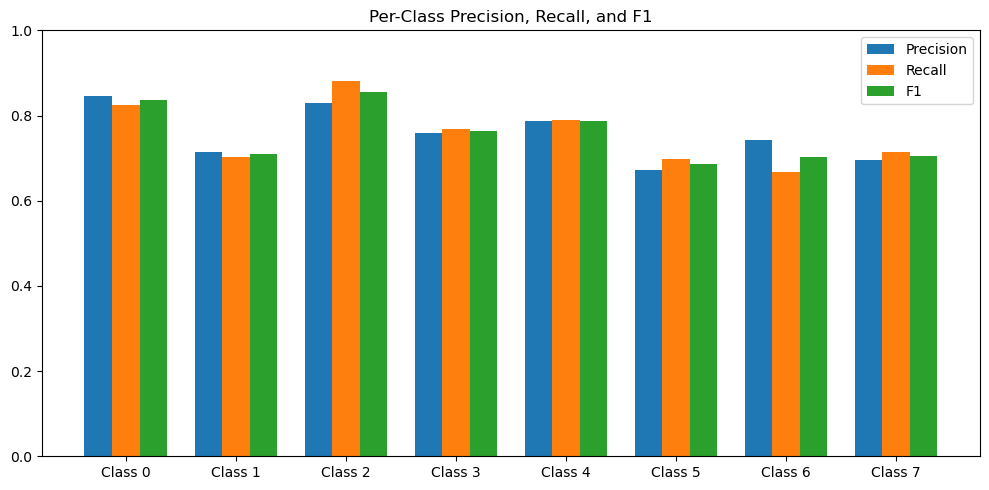

In [50]:
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1s, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)

x = np.arange(8)
width = 0.25

plt.figure(figsize=(10, 5))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1s, width, label='F1')

plt.xticks(x, [f'Class {i}' for i in range(8)])
plt.ylim(0.0, 1.0)
plt.legend()
plt.title('Per-Class Precision, Recall, and F1')
plt.tight_layout()
plt.savefig('per_class_metrics.png')
plt.show()